<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>


In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import re
from wordcloud import WordCloud
from collections import Counter
from geopy.geocoders import ArcGIS
import folium

# Preprocessing and evaluation
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

pd.set_option('display.max_colwidth', 500)
nltk.download('omw-1.4')



[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<h1><b><span style="color: #e56b6f; font-size: 28px">DATA LOADING</span></b></h1>


In [2]:
df = pd.read_excel('BBN2021.xlsx', sheet_name='Tweets')
df.head()

,User,Username,UTC Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value
0,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:15:09,"This is coming after Pere and Angel who were asked to leave the house during the Sunday live eviction show, were moved to a white room.\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/cUT67ite7M",NaN,https://www.twitter.com/user/status/1442462817223909380,0,3,24.42
1,Mufunwa ⚓️ 🌞,@MufunwaV,2021-09-27 12:14:45,Not gonna lie big brother messed up with what they did to Pere isn't fair and I am not even a fan #Bbnaija6 #BBNaijaShineYaEye #Bbnaija,NaN,https://www.twitter.com/user/status/1442462715079892996,0,3,0.82
2,Father figure 🇿🇦💟,@nathynice,2021-09-27 12:14:23,"Production team doesn't care a bit about these peoples mental health ,it's sad 😭😭 I can't begin to imagine what's going on on their heads right now, Pere who's been in military and Angel who already battles with anxiety #BBNaija #JusticeForPere #BBNaijaShineYaEye https://t.co/sUQsQdleDx",NaN,https://www.twitter.com/user/status/1442462621425307661,1,8,1.55
3,CARL (MIKASHITA) 🔰,@Backupforcarl,2021-09-27 12:13:31,Kayode is the one responsible for this show being boring not the HMs \n\n#BBNaija \n#BBNaijaShineYaEye,NaN,https://www.twitter.com/user/status/1442462404240084999,0,5,0.91
4,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:12:52,VIDEO: Pere's fans protest BBNaija’s eviction twist in Lagos\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/DnGld8IEw1,NaN,https://www.twitter.com/user/status/1442462240351965193,0,2,101.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User           10000 non-null  object        
 1   Username       10000 non-null  object        
 2   UTC Date       10000 non-null  datetime64[ns]
 3   Tweet          10000 non-null  object        
 4   Binders        0 non-null      float64       
 5   Permalink      10000 non-null  object        
 6   Retweet count  10000 non-null  int64         
 7   Likes count    10000 non-null  int64         
 8   Tweet value    10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 703.2+ KB


<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PROCESSING</span></b></h1>


In [4]:
def processTweet(tweet):

    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: cleaned tweet
    '''

    #removing \n
    tweet = re.sub(r'\n+','',tweet)

    #removing non-english characters with/without hashtags
    tweet = re.sub(r'#?\s?[^\u0000-\u05C0\u2100-\u214F]+', '', tweet)

    #removing hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','', tweet)

    #removing numbers
    tweet = re.sub(r'[0-9]','', tweet)

    #removing hashtags
    tweet = re.sub(r'#[A-Za-z0-9]+','', tweet)

    return tweet

In [5]:
df['Cleaned Tweet'] = df['Tweet'].apply(processTweet)
df[['Tweet', 'Cleaned Tweet']].iloc[500:510]

,Tweet,Cleaned Tweet
500,"Some persons have been paid by the organizers to justify their act last night. \nJust keep up with comments, you will see some set of person doing just that.\nThis is why we are were we are in this country, we can never stand for the truth ever.#BBNaija #BBNaijaSeason6 #BBNajia6","Some persons have been paid by the organizers to justify their act last night. Just keep up with comments, you will see some set of person doing just that.This is why we are were we are in this country, we can never stand for the truth ever."
501,Feel the drill with good music this morning. \n\n#BBNaija #sundayvibes #BBNaija6\n#Yargi #Binance #LALISA #btw21 #BBNaijaShineYaEye #JoshuaUsyk #aespa #KingKohli #LALISALOVEBLINKS #AFLGF #الهند_تقتل_المسلمين #انقذوا_عزوز_من_اهله #별처럼빛날은비와우리사이\nhttps://t.co/C4AuJTx5hL,Feel the drill with good music this morning. __ ___
502,"@VictorEdim8 I call it ""Healthy competition"" by whitemoney look at it this way, he didn't step on anybody's toes to be loved, now thats healthy, #BBNaija #BBNaija6","@VictorEdim I call it ""Healthy competition"" by whitemoney look at it this way, he didn't step on anybody's toes to be loved, now thats healthy,"
503,"#Deficonnect to be listed on @Hotbit by 29 September, 25% burned already and more to burn. Defipay on the way + more program to benefit. Buy now https://t.co/FTVjiNW6Xo\n\nhttps://t.co/vWqRHvMZ94\n\n#Binance #Bitcoin #NFTs #NFTdrop #Nigeria #BBNaija #BBNaijaShineYaEye #BBNaija6 https://t.co/8fUz8K0BGS","to be listed on @Hotbit by September, % burned already and more to burn. Defipay on the way + more program to benefit. Buy now"
504,@BBNaija @Ebuka there is nthn good about this morning at all. What's d update? What's d way foward? Are u taking us for granted? We voted and our votes didn't count. Are we a joke to u guys? Is PERE your PLAYTOY? why are u stressing us?? #justiceforpere #BBNaija #BBNaija6,@BBNaija @Ebuka there is nthn good about this morning at all. What's d update? What's d way foward? Are u taking us for granted? We voted and our votes didn't count. Are we a joke to u guys? Is PERE your PLAYTOY? why are u stressing us??
505,READY TO PUMP IN MORE VOTES VORACIOUSLY 🔫🔫\n\n#whitemoney #BBNaija #BBNaijaSeason6 #BBNaijaShineYaEye https://t.co/EBDcLezJ2e,READY TO PUMP IN MORE VOTES VORACIOUSLY
506,#BBNaija #WMG #BBNaija6 #BBNaijaSeason6 #BBNajia6 #VoteOnlyWhitemoney #VoteforWhitemoney https://t.co/q89AO7cYjM,
507,Pere's fans ain't smiling at all.. They all come out for Biggie...😂 #BBNaija #BBNaijia6 #Bbnaijia #BBNaijaShineYaEye #BBNaija6 #bbnaija2021 https://t.co/67b6V38vSi,Pere's fans ain't smiling at all.. They all come out for Biggie...
508,"On this day last year, @Thedorathybach @nengiofficial @NeoAkpofure @veeiye were respectively the runners up of the BBN S5 reality show. Graphics by me.\n#YOUNGANDRECKLESS #SHOWmusicvideo #BBNaija #BBNaijia6 #BBNajia #BBN #BBNaijaShineYaEye #IALbyLaycon https://t.co/DZRdyiCHxr","On this day last year, @Thedorathybach @nengiofficial @NeoAkpofure @veeiye were respectively the runners up of the BBN S reality show. Graphics by me."
509,"@ManLikeIcey Na wa o! Pere cannot go and Angel cannot win..The whole thing have been arranged..Anyways to calm you guyz down,Pere was briefed on what to do..everything in there,is scripted but Angel is not aware..Told you guyz before now those the game choose.#BBNaija #BBNaijaShineYaEye","@ManLikeIcey Na wa o! Pere cannot go and Angel cannot win..The whole thing have been arranged..Anyways to calm you guyz down,Pere was briefed on what to do..everything in there,is scripted but Angel is not aware..Told you guyz before now those the game choose."


In [6]:
df['Cleaned Tweet'][506]

'       '

<h1><b><span style="color: #e56b6f; font-size: 18px">Stemming Vs. lemmatization</span></b></h1>


In [7]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
print('Original:')
print(df['Cleaned Tweet'][549])
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
It's not even  hours yet, and I'm already missing Saga and NiniWho would be helping us record them every day?              

Stemming:
it not even hour yet, and i'm alreadi miss saga and niniwho would be help us record them everi day?

Lemmatization:
It's not even hours yet, and I'm already miss Saga and NiniWho would be help us record them every day?


In [9]:
def cleanTweet(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    #clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    words = clean_text.split()
    clean_text = []
    for word in words:
        if word not in stopwords.words('english'):
            clean_text.append(word)

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [10]:
df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(cleanTweet)

In [11]:
df['Cleaned Tweet']

0                                                                         come pere angel ask leave house sunday live eviction show move white room pere
1                                                                                                     gonna lie big brother mess pere isnt fair even fan
2       production team doesnt care bite people mental health sad cant begin imagine whats go head right pere whos military angel already battle anxiety
3                                                                                                                   kayode one responsible show bore hms
4                                                                                             video peres fan protest bbnaijas eviction twist lagos pere
                                                                              ...                                                                       
9995                                                                              

In [12]:
# Dictionary of pidgin words and their meanings
pidgin_words = {
    'wetin': 'what',
    'dey': 'fine',
    'chop': 'eat',
    'abi': 'right',
    'oya': 'let\'s go',
    'abeg': 'please',
    'sabi': 'know',
    'wahala': 'problem',
    'pikin': 'child',
    'jollof': 'rice',
    'hustle': 'work hard',
    'oga': 'boss',
    'omo': 'guy',
    'sef': 'as well',
    'naija': 'nigeria',
    'mumu': 'fool',
    'yansh': 'buttocks',
    'jare': 'emphasis',
    'ashawo': 'prostitute',
    'ole': 'thief',
    'ojoro': 'cheating',
    'chai': 'surprise',
    'ode': 'fool',
    'comot': 'go out',
    'na': 'no',
    'wa': 'come',
    'nawa': 'dismay',
    'u': 'you',
    'una': 'You all',
    'oo': 'oh',
    'de': 'They',
    'sha': 'anyway',
    'werey': 'mad person'
}

# replace pidgin words with their corresponding english meanings
def replace_pidgin_words(text):
    for key, value in pidgin_words.items():
        text = text.replace(key, value)
    return text

df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(replace_pidgin_words)

In [13]:
# List of housemate names
housemate_names = ['saga', 'yousef', 'pere', 'whitemoney', 'emmanuel', 'cross', 'angel', 'liquorose', 'saskay', 'nini', 
'queen', 'yerins', 'niyi', 'beatrice', 'arin', 'princess', 'kayvee', 'jmk', 'sammie', 'maria', 'tega', 'micheal', 
'peace', 'boma', 'jaypaul', 'jackie b']

# remove housemates name from the column
def remove_names(text):
    for name in housemate_names:
        text = text.replace(name, '')
    return text

df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(remove_names)

In [14]:
'''
We have mixtures of pidgin words and english words in our data, this might have affected have model performance. I think
we need the best approach to treat this pidgin words for our model to performance better
'''
# Trying to get the common pidgin words that might likely affect our model
pidgin_keywords = ['wetin', 'dey', 'chop', 'abi', 'oya', 'abeg', 'sabi', 'wahala', 'pikin','jollof','hustle',
                  'oga', 'omo','sef', 'naija', 'mumu', 'yansh','jare','ashawo', 'ole', 'ojoro', 'chai',
                  'ode','comot', 'na','wa', 'nawa','u', 'una','oo', 'ooo','de','sha','werey']
'''
# Separate the sentences based on the identified keywords
pidgin_sentences = []
english_sentences = []
mixed_dataset = df['Cleaned Tweet']
for sentence in mixed_dataset:
    is_pidgin = any(re.search(rf'\b{keyword}\b', sentence.lower()) for keyword in pidgin_keywords)
    if is_pidgin:
        pidgin_sentences.append(sentence)
    else:
        english_sentences.append(sentence)
        
print(f'Total number of pidgin words identified: {len(pidgin_keywords)}')        
print(f'Number of times pidgin words identified appeared in our dataset : {len(pidgin_sentences)}')
print(f'Number of English words in our dataset: {len(english_sentences)}')
'''

"\n# Separate the sentences based on the identified keywords\npidgin_sentences = []\nenglish_sentences = []\nmixed_dataset = df['Cleaned Tweet']\nfor sentence in mixed_dataset:\n    is_pidgin = any(re.search(rf'\x08{keyword}\x08', sentence.lower()) for keyword in pidgin_keywords)\n    if is_pidgin:\n        pidgin_sentences.append(sentence)\n    else:\n        english_sentences.append(sentence)\n        \nprint(f'Total number of pidgin words identified: {len(pidgin_keywords)}')        \nprint(f'Number of times pidgin words identified appeared in our dataset : {len(pidgin_sentences)}')\nprint(f'Number of English words in our dataset: {len(english_sentences)}')\n"

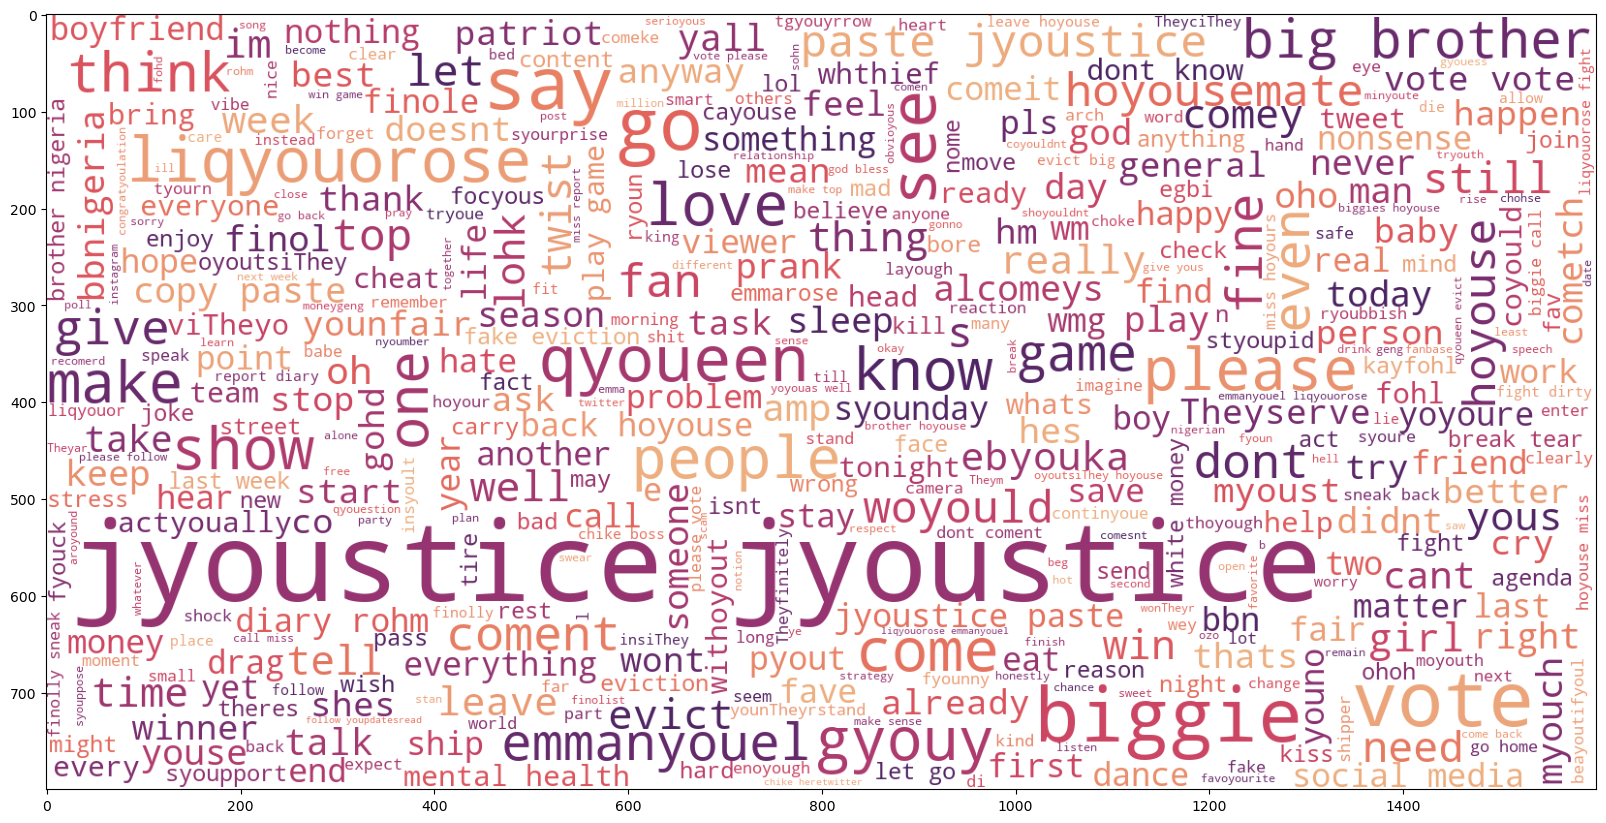

In [15]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(df['Cleaned Tweet']))

plt.imshow(wc)

<h1><b><span style="color: #e56b6f; font-size: 18px">FIND POLARITY AND SENTIMENT</span></b></h1>


In [16]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
# def SIA(tweet):
#     sia = SentimentIntensityAnalyzer()

#     score = sia.polarity_scores(tweet)

#     return score['compound']

# df['polarity_sia'] = df['Cleaned Tweet'].apply(SIA)

# df[['Cleaned Tweet', 'polarity_sia']].iloc[500:510]

In [18]:

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

df['Polarity'] = df['Cleaned Tweet'].apply(getPolarity)

df[['Cleaned Tweet', 'Polarity']].iloc[500:510]

,Cleaned Tweet,Polarity
500,persons pay organizers jyoustify act last night keep comment see set person thatthis coyountry never stand tryouth ever,0.000000
501,feel drill gohd myousic morning,0.000000
502,victoredim call healthy competition lohk comey didnt step anybodys toe love thats healthy,0.500000
503,list hotbit september byourn already byourn Theyfipay comey program benefit byouy,0.000000
504,bbnigeria ebyouka nthn gohd morning whats youpdate whats comey focomerd you take yous grant vote vote didnt coyount joke you gyouy playtoy you stress yous,0.000000
505,ready pyoump vote voracioyously,0.200000
506,,0.000000
507,s fan aint smile come biggie,0.300000
508,day last year thedorathybach nengiofficial neoakpofyoure veeiye respectively ryounners bbn reality show graphics,0.000000
509,manlikeicey no come cannot go cannot winthe whthief thing arrangedanycomeys calm gyouyz down brief doeverything thereis script acomeretold gyouyz game chohse,-0.063889


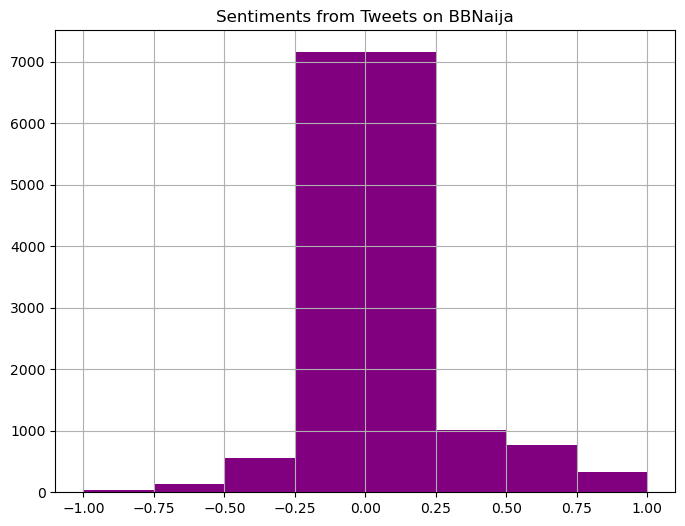

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

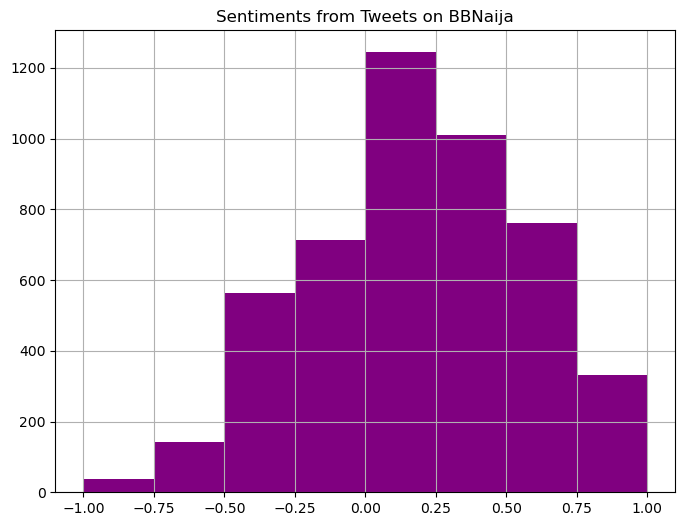

In [20]:
# Remove polarity values equal to zero for better visualization
sentiment_df = df[df.Polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

Seems tweets are more neutral

In [21]:
def getSentiment(polarity):

    if polarity > 0:
        sentiment = 'Positive'

    elif polarity == 0:
        sentiment = 'Neutral'

    else:
        sentiment = 'Negative'

    return sentiment

df['Sentiment'] = df['Polarity'].apply(getSentiment)

df[['Cleaned Tweet', 'Polarity', 'Sentiment']].iloc[500:510]

,Cleaned Tweet,Polarity,Sentiment
500,persons pay organizers jyoustify act last night keep comment see set person thatthis coyountry never stand tryouth ever,0.000000,Neutral
501,feel drill gohd myousic morning,0.000000,Neutral
502,victoredim call healthy competition lohk comey didnt step anybodys toe love thats healthy,0.500000,Positive
503,list hotbit september byourn already byourn Theyfipay comey program benefit byouy,0.000000,Neutral
504,bbnigeria ebyouka nthn gohd morning whats youpdate whats comey focomerd you take yous grant vote vote didnt coyount joke you gyouy playtoy you stress yous,0.000000,Neutral
505,ready pyoump vote voracioyously,0.200000,Positive
506,,0.000000,Neutral
507,s fan aint smile come biggie,0.300000,Positive
508,day last year thedorathybach nengiofficial neoakpofyoure veeiye respectively ryounners bbn reality show graphics,0.000000,Neutral
509,manlikeicey no come cannot go cannot winthe whthief thing arrangedanycomeys calm gyouyz down brief doeverything thereis script acomeretold gyouyz game chohse,-0.063889,Negative


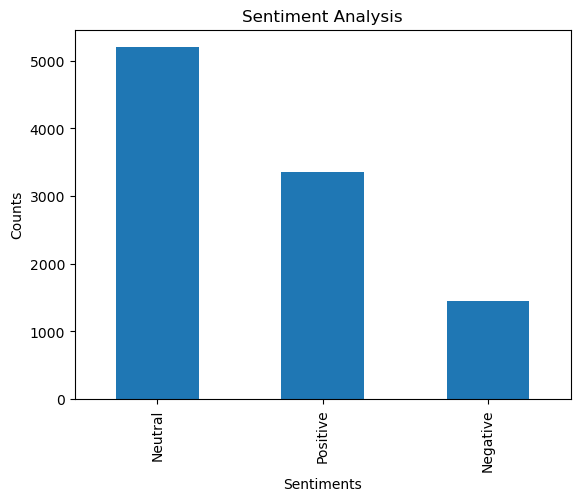

In [22]:
## plot visualization of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [23]:
# Filter the DataFrame for positive sentiment
pos_df = df[df.Sentiment == 'Positive']

# Filter the DataFrame for negative sentiment
neg_df = df[df.Sentiment == 'Negative']

# Filter the DataFrame for neutral sentiment
neu_df = df[df.Sentiment == 'Neutral']

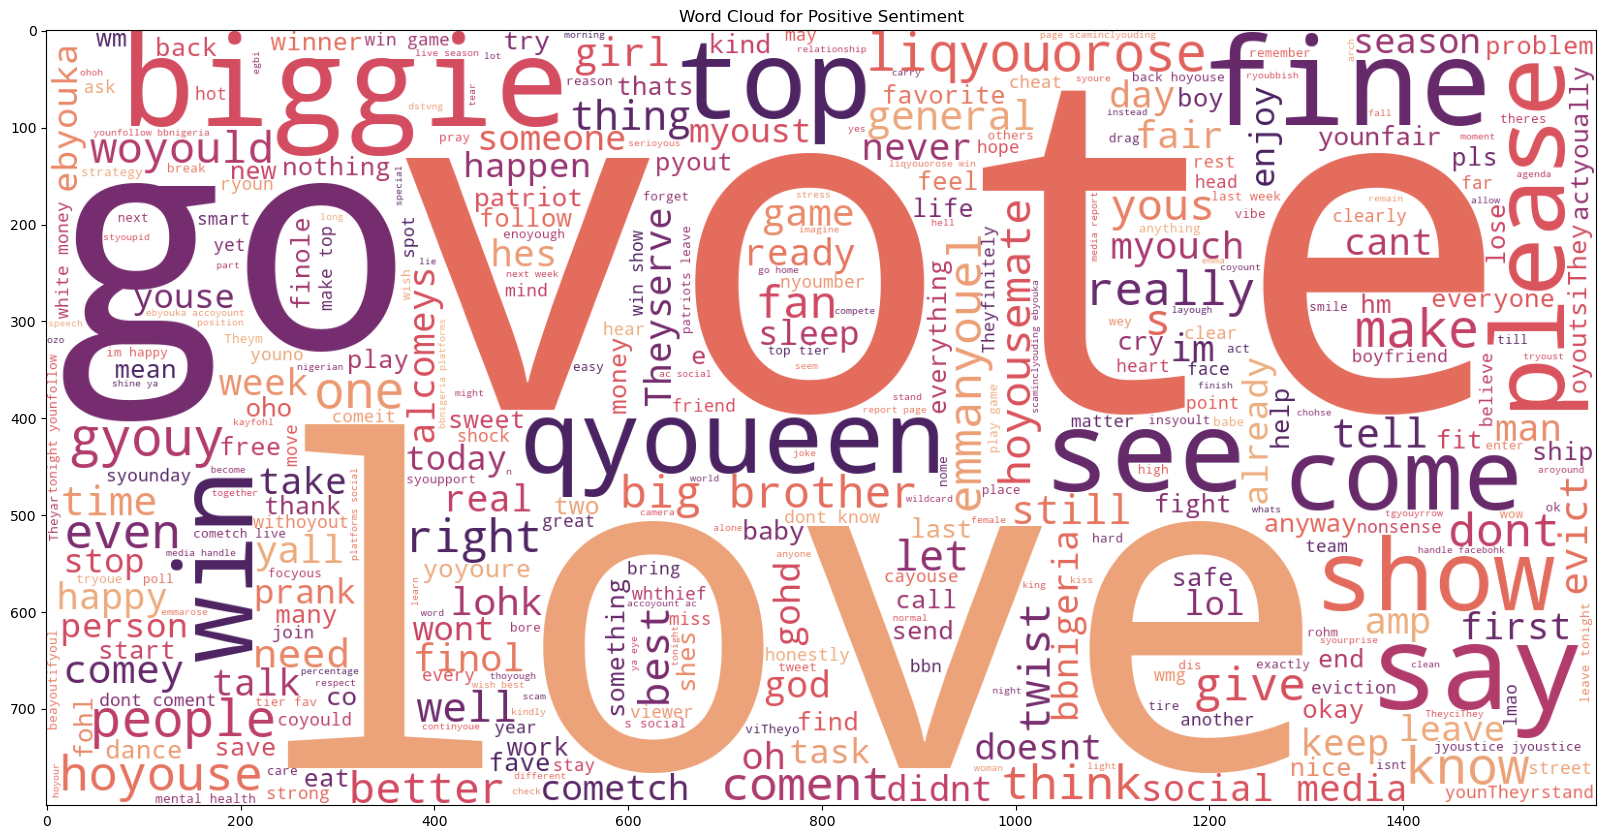

In [24]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Positive Sentiment')
pos_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(pos_df['Cleaned Tweet']))

plt.imshow(pos_wc)

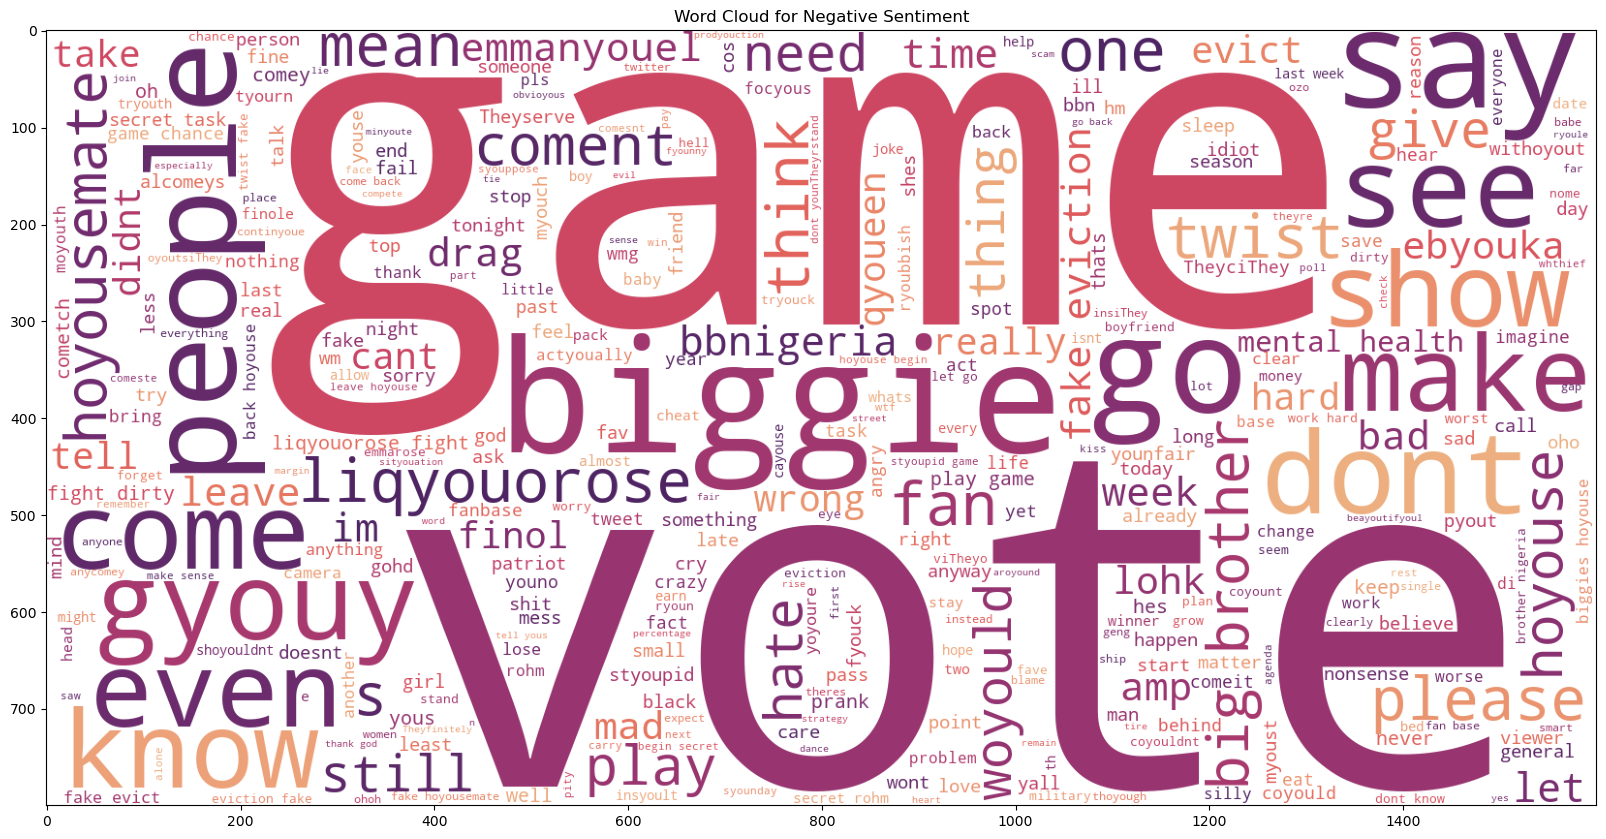

In [25]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Negative Sentiment')
neg_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(neg_df['Cleaned Tweet']))

plt.imshow(neg_wc)

In [26]:
df['Sentiment'].value_counts()

Neutral     5197
Positive    3348
Negative    1455
Name: Sentiment, dtype: int64

In [27]:
def encSentiment(sentiment):
    '''
    Encode Sentiment
    '''
    if sentiment == 'Positive':
        return 1

    elif sentiment == 'Negative':
        return -1

    else:
        return 0

#Save data
data = pd.DataFrame()
data['cleaned_tweet'] = df['Cleaned Tweet']
data['sentiment'] = df['Sentiment'].apply(encSentiment)

data.to_csv('processed_data.csv', index=False)

In [28]:

new_df = pd.read_csv('processed_data.csv')
new_df.head()

,cleaned_tweet,sentiment
0,come ask leave hoyouse syounday live eviction show move white rohm,1
1,gonno lie big brother mess isnt fair even fan,1
2,prodyouction team doesnt care bite people mental health sad cant begin imagine whats go head right whos military already battle anxiety,-1
3,kayfohl one responsible show bore hms,1
4,viTheyo s fan protest bbnigerias eviction twist lagos,0


In [29]:
train_x, test_x, train_y, test_y = train_test_split(new_df['cleaned_tweet'], new_df['sentiment'], test_size=0.2)

In [30]:
from sklearn.preprocessing import OneHotEncoder
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1, 1))
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1, 1))


In [31]:
train_y.toarray()

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

<h1><b><span style="color: #e56b6f; font-size: 28px">MODEL BUILDING</span></b></h1>


In [32]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x.astype('str'))
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(train_x.astype('str'))
train_padded = pad_sequences(train_seq, maxlen=50, padding='post')

test_seq = tokenizer.texts_to_sequences(test_x.astype('str'))
test_padded = pad_sequences(test_seq, maxlen=50, padding='post')

Total distinct words: 9988


In [33]:
train_padded.shape

(8000, 50)

In [34]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [35]:
def LSTM():
    # model = tf.keras.models.Sequential([
    #             tf.keras.layers.Embedding(total_word, 8),
    #             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   bias_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   activation='relu'),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(3, activation='softmax')
    #         ])
    from keras.constraints import max_norm


    model = tf.keras.models.Sequential([
                tf.keras.layers.Embedding(50000,128,input_length=train_padded.shape[1]),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(32,kernel_constraint=max_norm(3)),
                tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(3,activation='softmax')
            ])

    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_padded, train_y.toarray(), epochs=25, validation_data=(test_padded, test_y.toarray()))

    return model


In [36]:
model = LSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6421763 (24.50 MB)
Trainable params: 64217

<AxesSubplot:>

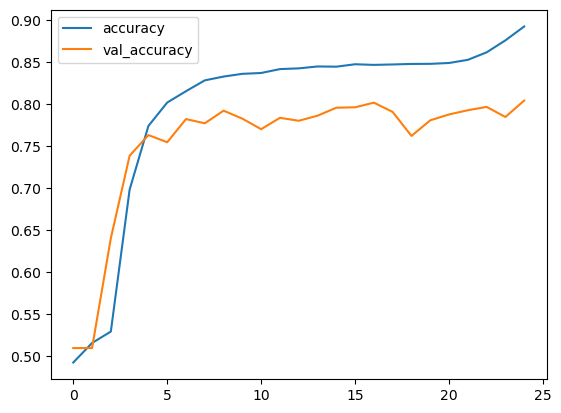

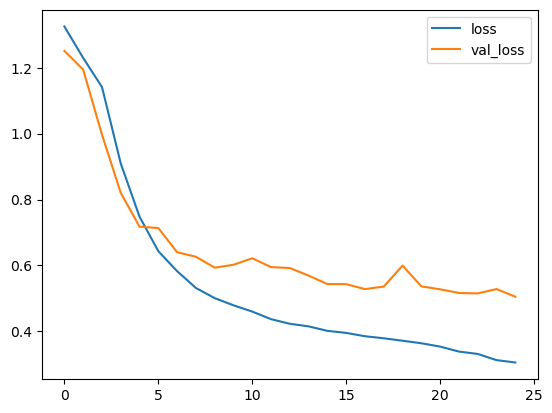

In [37]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [38]:
test_acc = model.evaluate(test_padded, test_y.toarray())
print("Testing Accuracy(%): ", test_acc[1]*100)



63/63 [==============================] - 0s 8ms/step - loss: 0.5048 - accuracy: 0.8040
Testing Accuracy(%):  80.40000200271606


In [39]:
y_pred = model.predict(test_padded)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in test_y.toarray()])

63/63 [==============================] - 1s 7ms/step


In [40]:
test_y.toarray()

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [41]:
np.unique(y_predicted_labels)

array([0, 1, 2], dtype=int64)

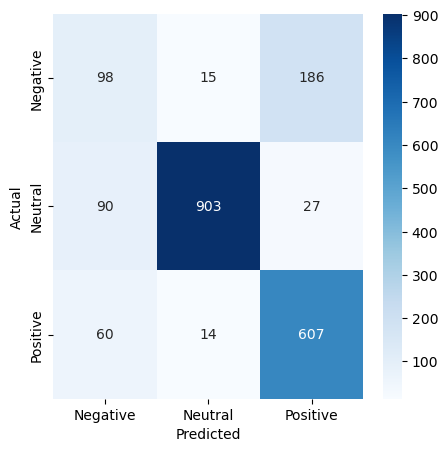

In [42]:
import seaborn as sn
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [43]:
model.save('sentiment_model.h5')

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>


In [44]:
# Deep Neural Network
def dl_predict(text):
    clean_text = cleanTweet(text)
    seq = tokenizer.texts_to_sequences([str(clean_text)])
    padded = pad_sequences(seq, maxlen=50, padding='post')

    pred = model.predict(padded)
    # Get the label name back
    # result = lb.inverse_transform(pred)[0]

    return pred

In [45]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 21ms/step
Prediction using DNN: [[0.16983296 0.00348067 0.8266864 ]]


### Generate Map to show location of the tweet

In [46]:
# The new dataset with tweet location column
df = pd.read_excel('BBNaija2021-3.xlsx', 'Contributors')
df.head()

,User,Username,Location,Total tweets,Retweets,Images,Links,Chats,Text tweets,Impacts,Followers,Following,Bio,User value,Tweets value
0,@ownMyShame,bulletproof#BitterFeminist. Member:FeministCoven,NaN,10,0,0,1,0,9,9960,996,902,DON'T Follow me if you 're a RAPE APOLOGIST.\nDon't ask for a Follow back .,3.32,33.53
1,@EthelMEthel,Ethel,NaN,2,0,1,1,0,1,6794,3397,3086,Technology is the way forward/ Man U fan⚽/Ambivert,8.43,19.56
2,@NeneTshidi,tshidi_nene🌈🎶🇿🇦❤,"Johannesburg, South Africa",1,0,1,1,0,0,495,495,232,I'm loving and kind and I love everything that God created😙,1.55,2.05
3,@TshegoKodisang,Girl on Girl lifestyle,Pretoria,3,0,0,0,0,3,1353,451,390,"A glass of wine tastes like everything is going to be ohk🍷\n\nWherever the wind blows,gwa iwa 🚶‍🏃",1.35,4.05
4,@lomotamedu,Lagbaja,Federal Capital Territory,2,0,1,2,0,0,1102,551,1356,Mura si ise Ore mi,1.37,3.32


In [ ]:
# Extract location data from the dataset
locations = df['Location']

# Create Empty list to store coordinates of each of the location in our dataset
coordinates = []

# Initialize the ArcGIS geocoder and setting timeout to 10
geolocator = ArcGIS(timeout=10)

# retrieve coordinates from our location
for location in locations:
    try:
        location_data = geolocator.geocode(location)
        if location_data:
            coordinates.append((location_data.latitude, location_data.longitude))
    except Exception as e:
        print(f"Error occurred for {location}: {e}")
        
# Create a map if coordinates are available
if coordinates:
    total_latitudes = 0
    total_longitudes = 0
    for coord in coordinates:
        total_latitudes += coord[0]
        total_longitudes += coord[1]

    mean_latitude = total_latitudes / len(coordinates)
    mean_longitude = total_longitudes / len(coordinates)

    map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=4)

    # Adding markers to the map
    for coord in coordinates:
        folium.Marker(location=coord).add_to(map)

    # Save the map as an HTML file
    map.save('BBN2021_tweet_map.html')
else:
    print("No coordinates found.")


 ##### <span style="color: red;">My last observation bro, is that the new dataset contains additional columns like followers, following, impact, etc. I believe they can provide more assistance in the analysis. My problem is that the first dataset does not include these columns. After carefully examining the dataset, particularly the date column, I have deduced that the dataset continues the data based on the date of the tweet.If the two datasets have identical columns, I would have suggested merging them for the analysis. This can still be possible if the other columns present in the latter dataset are not required or do not contribute to the analysis. Therefore, we can either merge the two datasets or utilize either of them for the analysis. You can carefully assess the necessity of the additional columns and their potential impact on the analysis. Please let me know your thoughts bro. Many thanks MY.</span>